<a href="https://colab.research.google.com/github/aydawudu/Transformers_Practice/blob/main/Fine_Tuning_Sentiment_Analysis_With_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 28.4 MB/s 
     |████████████████████████████████| 441 kB 54.5 MB/s 
     |████████████████████████████████| 163 kB 59.5 MB/s 
     |████████████████████████████████| 7.6 MB 31.6 MB/s 
     |████████████████████████████████| 212 kB 58.3 MB/s 
     |████████████████████████████████| 95 kB 5.3 MB/s 
     |████████████████████████████████| 115 kB 58.9 MB/s 
     |████████████████████████████████| 127 kB 52.8 MB/s 
     |████████████████████████████████| 115 kB 48.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6


In [ ]:
#data from# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-10-31 19:52:52--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  1.11MB/s    in 2.9s    

2022-10-31 19:52:57 (1.11 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [ ]:
#import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [ ]:
#load data
df_=pd.read_csv('AirlineTweets.csv')

In [ ]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
df=df_[['airline_sentiment', 'text']].copy()

In [ ]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


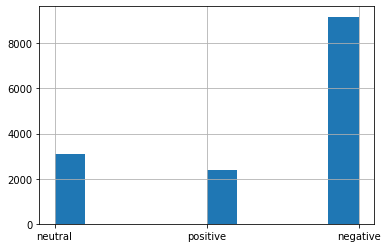

In [ ]:
df['airline_sentiment'].hist()

In [ ]:
target_map={'positive':1, 'negative':0, 'neutral':2}
df['target']=df['airline_sentiment'].map(target_map)

In [ ]:
df.head()

,airline_sentiment,text,target
0,neutral,@VirginAmerica What @dhepburn said.,2
1,positive,@VirginAmerica plus you've added commercials t...,1
2,neutral,@VirginAmerica I didn't today... Must mean I n...,2
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0


In [ ]:
df2=df[['text','target']]
df2.columns=['sentence', 'label'] #important, the target column must have a column name 'label'
df2.to_csv('data.csv', index=None)

In [ ]:
df2.head()

,sentence,label
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [ ]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [ ]:
from datasets import load_dataset #load the data into a hugging face dataset format
raw_dataset=load_dataset('csv', data_files='data.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-7c110faa78f7fc75/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [ ]:
split=raw_dataset['train'].train_test_split(test_size=0.3, seed=42)
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [ ]:
# if you have multiple csv files
# load_dataset('csv', data_files=['file1.csv', 'file2.csv'])

#if you already have a train-test split:
#load_dataset(
#     'csv',
#     data_files={'train':['train1.csv', 'train2.csv'],
#                 'test':'test.csv'}
# )

In [ ]:
checkpoint='distilbert-base-cased'

In [ ]:
from transformers import AutoTokenizer

In [ ]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], truncation=True)

In [ ]:
tokenized_datasets=split.map(tokenize_fn, batched=True)

  0%|          | 0/11 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

In [ ]:
model=AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

Downloading:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'pre_classifier

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

In [ ]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [ ]:
#set up the training argument object specifying the batch size
training_args=TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    
)

In [ ]:
def compute_metrics(logits_and_labels):
  logits, labels=logits_and_labels
  predictions=np.argmax(logits, axis=-1)
  acc=np.mean(predictions ==labels)
  f1=f1_score(labels, predictions, average='macro')
  return {'accuracy':acc, 'f1':f1}

In [ ]:
trainer=Trainer(
    model,
    training_args, 
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10248
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1923
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the te

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.546900,0.430701,0.832423,0.777610
2,0.346500,0.481003,0.833106,0.786115
3,0.239300,0.638591,0.835383,0.780995


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4392
  Batch size = 64
Saving model checkpoint to training_dir/checkpoint-641
Configuration saved in training_dir/checkpoint-641/config.json
Model weights saved in training_dir/checkpoint-641/pytorch_model.bin
tokenizer config file saved in training_dir/checkpoint-641/tokenizer_config.json
Special tokens file saved in training_dir/checkpoint-641/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation

TrainOutput(global_step=1923, training_loss=0.3267275333652506, metrics={'train_runtime': 217.015, 'train_samples_per_second': 141.668, 'train_steps_per_second': 8.861, 'total_flos': 388376501242176.0, 'train_loss': 0.3267275333652506, 'epoch': 3.0})

In [ ]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [ ]:
from transformers import pipeline

In [ ]:
savedmodel=pipeline('text-classification',
                    model='training_dir/checkpoint-1282',
                    device=0)

loading configuration file training_dir/checkpoint-1282/config.json
Model config DistilBertConfig {
  "_name_or_path": "training_dir/checkpoint-1282",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.23.1",
  "vocab_size": 28996
}

loading configuration file training_dir/checkpoint-1282/config.json
Model config DistilBertConfig {
  "_

In [ ]:
split['test'] #how to access the test set

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [ ]:
test_pred=savedmodel(split['test']['sentence'])

Disabling tokenizer parallelism, we're using DataLoader multithreading already


In [ ]:
test_pred[:10]

[{'label': 'LABEL_1', 'score': 0.9686180353164673},
 {'label': 'LABEL_1', 'score': 0.9099698662757874},
 {'label': 'LABEL_1', 'score': 0.8083460330963135},
 {'label': 'LABEL_1', 'score': 0.8895406723022461},
 {'label': 'LABEL_2', 'score': 0.9147451519966125},
 {'label': 'LABEL_0', 'score': 0.9939004182815552},
 {'label': 'LABEL_2', 'score': 0.9646121859550476},
 {'label': 'LABEL_2', 'score': 0.9480656385421753},
 {'label': 'LABEL_1', 'score': 0.5766932964324951},
 {'label': 'LABEL_0', 'score': 0.9942278861999512}]

In [ ]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_pred=[get_label(d) for d in test_pred]

In [ ]:
test_pred[:10]

[1, 1, 1, 1, 2, 0, 2, 2, 1, 0]

In [ ]:
print("acc:", accuracy_score(split['test']['label'], test_pred))

acc: 0.8331056466302368


In [ ]:
print("f1:", f1_score(split['test']['label'], test_pred, average='macro'))

f1: 0.7861146229721389


In [ ]:
cm=confusion_matrix(split['test']['label'], test_pred, normalize='true')

In [ ]:
def plot_cm(cm):
  classes=['negative', 'positive', 'neutral']
  df_cm=pd.DataFrame(cm, index=classes, columns=classes)
  ax=sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

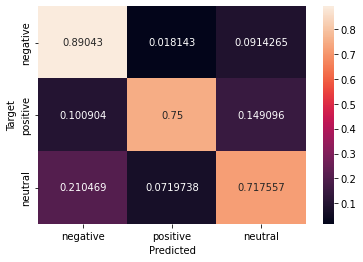

In [ ]:
plot_cm(cm)